In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta

### Carga de datos

In [2]:
bases = pd.read_csv('C:/Users/asus/Desktop/data/bases_bicimad.csv', sep=';', encoding='ISO-8859-1')
bicis = pd.read_csv('C:/Users/asus/Desktop/data/bike_data.csv')

Unimos ambos dataframes en uno solo

In [3]:
bicis['idunplug_station'] = bicis['idunplug_station'].astype(str)
df = bicis.merge(bases, how='left', left_on='idunplug_station', right_on='Número')

### Preprocesado de las variables

Como vimos en el analisis exploratorio, consideraremos outliers los registros cuyo tiempo de viaje sea superior a 2000 segundos

Vamos a crear variables nuevas a partir del tipo de usuario y de la edad, que nos indiquen agrupando por el dia y la hora en la que se efectúa el trayecto nos indique el porcentaje de usuarios para cada tipo y rango

Extraemos los el dia y la hora a partir de la fecha de desenganche

In [4]:
bicis['fechas'] = pd.to_datetime(bicis.unplug_hourTime)
bicis['fechas_utc2'] = bicis.fechas+timedelta(hours=2)
bicis['day'] = bicis.fechas_utc2.apply(lambda x: x.day)
bicis['hour'] = bicis.fechas_utc2.apply(lambda x: x.hour)

Como el dia de la semana es importante para ver el número de trayectos realizados, vamos a crear una nueva variable que nos indique si un dia es fin de semana (1) o no (0)

In [5]:
bicis['finde'] = bicis.fechas_utc2.apply(lambda x: 1 if x.isoweekday()>5 else 0)

Veamos la cantidad de trayectos agrupdos por dia y por hora

In [7]:
df = bicis.groupby(['day', 'hour']).size().reset_index().rename(columns={0:'trayectos'})
df.head(10)

,day,hour,trayectos
0,1,1,553
1,1,2,438
2,1,3,309
3,1,4,244
4,1,5,166
5,1,6,158
6,1,7,130
7,1,8,187
8,1,9,286
9,1,10,342


Generamos las nuevas variables a partir del rango y del tipo

In [8]:
bicis['tipo0'] = np.where(bicis.user_type==0,1,0)
bicis['tipo1'] = np.where(bicis.user_type==1,1,0)
bicis['tipo2'] = np.where(bicis.user_type==2,1,0)
bicis['tipo3'] = np.where(bicis.user_type==3,1,0)


In [9]:
bicis['range0'] = np.where(bicis.ageRange==0,1,0)
bicis['range1'] = np.where(bicis.ageRange==1,1,0)
bicis['range2'] = np.where(bicis.ageRange==2,1,0)
bicis['range3'] = np.where(bicis.ageRange==3,1,0)
bicis['range4'] = np.where(bicis.ageRange==4,1,0)
bicis['range5'] = np.where(bicis.ageRange==5,1,0)
bicis['range6'] = np.where(bicis.ageRange==6,1,0)


Sumamos las nuevas variables agrupadas por dia y hora para ver cantidades abolutas de cada una

In [10]:
a1 = bicis.groupby(['day', 'hour']).agg({'tipo0':'sum', 'tipo1':'sum', 'tipo2':'sum', 'tipo3':'sum'}).reset_index()

In [11]:
a2 = bicis.groupby(['day', 'hour']).agg({'range0':'sum', 'range1':'sum', 'range2':'sum', 'range3':'sum', 'range4': 'sum',
                                        'range5': 'sum', 'range6': 'sum'}).reset_index()

Y lo unimos con el dataframe que contiene el numero de trayectos

In [12]:
df1 = df.merge(a1, how='left', on=['day', 'hour'])

In [13]:
df2 = df1.merge(a2, how='left', on=['day', 'hour'])

In [14]:
df2.head()

,day,hour,trayectos,tipo0,tipo1,tipo2,tipo3,range0,range1,range2,range3,range4,range5,range6
0,1,1,553,0,474,17,62,252,14,5,43,156,83,0
1,1,2,438,0,369,3,66,196,19,4,26,122,71,0
2,1,3,309,0,290,2,17,166,0,7,29,89,18,0
3,1,4,244,0,208,2,34,107,12,1,31,53,40,0
4,1,5,166,0,152,1,13,83,0,2,21,49,11,0


Calculamos los porcentajes, dividiendo cada columna por el numero de trayectos para ese dia y esa hora

In [15]:
df3 = df2.iloc[:, 3:].div(df2['trayectos'], axis=0)
df3.head()

,tipo0,tipo1,tipo2,tipo3,range0,range1,range2,range3,range4,range5,range6
0,0.0,0.857143,0.030741,0.112116,0.455696,0.025316,0.009042,0.077758,0.282098,0.150090,0.0
1,0.0,0.842466,0.006849,0.150685,0.447489,0.043379,0.009132,0.059361,0.278539,0.162100,0.0
2,0.0,0.938511,0.006472,0.055016,0.537217,0.000000,0.022654,0.093851,0.288026,0.058252,0.0
3,0.0,0.852459,0.008197,0.139344,0.438525,0.049180,0.004098,0.127049,0.217213,0.163934,0.0
4,0.0,0.915663,0.006024,0.078313,0.500000,0.000000,0.012048,0.126506,0.295181,0.066265,0.0


Y añadimos la duracion media de los trayectos por dia y hora

In [16]:
df4 = bicis.loc[bicis.travel_time<=2000].groupby(['day', 'hour']).agg({'travel_time':'mean'}).reset_index().rename(columns={0:'duracion_media'})
df4.head()


,day,hour,travel_time
0,1,1,746.216433
1,1,2,728.002695
2,1,3,655.066434
3,1,4,708.842342
4,1,5,649.918919


Unimos todos los dataframes para tener toda la información unificada

In [17]:
x1 = pd.concat([a1[['day', 'hour']], df3], axis=1)

In [18]:
x2 = x1.merge(df4, how='left', on=['day', 'hour'])

In [19]:
dia_finde = bicis.groupby(['day', 'finde']).size().reset_index()
x3 = x2.merge(dia_finde[['day', 'finde']], how='left', on='day')

Y finalmente tenemos el dataframe que servirá como input de nuestro modelo

In [20]:
dataset = df.merge(x3, how='left', on=['day', 'hour'])
dataset.head()

,day,hour,trayectos,tipo0,tipo1,tipo2,tipo3,range0,range1,range2,range3,range4,range5,range6,travel_time,finde
0,1,1,553,0.0,0.857143,0.030741,0.112116,0.455696,0.025316,0.009042,0.077758,0.282098,0.150090,0.0,746.216433,1
1,1,2,438,0.0,0.842466,0.006849,0.150685,0.447489,0.043379,0.009132,0.059361,0.278539,0.162100,0.0,728.002695,1
2,1,3,309,0.0,0.938511,0.006472,0.055016,0.537217,0.000000,0.022654,0.093851,0.288026,0.058252,0.0,655.066434,1
3,1,4,244,0.0,0.852459,0.008197,0.139344,0.438525,0.049180,0.004098,0.127049,0.217213,0.163934,0.0,708.842342,1
4,1,5,166,0.0,0.915663,0.006024,0.078313,0.500000,0.000000,0.012048,0.126506,0.295181,0.066265,0.0,649.918919,1


### Entrenamiento del modelo

En este caso usaremos un random forest regresor

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Definimos nuestro conjunto de features y el target, excluimos los usuarios sin tipo ni rango de edad

In [21]:
X = dataset.drop(columns=['trayectos', 'tipo0', 'range0']).values
y = dataset['trayectos'].values

Entrenamos el modelo con 70% train y 30% test, usaremos 1000 arboles de decision y criterio de error cuadratico medio al ser un regresor

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
forest = RandomForestRegressor(n_estimators=1000, criterion='mse', random_state=42, n_jobs=-1)
forest.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Veamos el MSE de nuestro modelo

In [25]:
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))

MSE train: 1764.144, test: 10255.370


vemos que el modelo tiene a sobreajustar al conjunto de train, al tener un error mucho menor en training que en test

In [27]:
print('R^2 train: %.3f, test: %.3f' % (forest.score(X_train, y_train), forest.score(X_test, y_test)))

R^2 train: 0.987, test: 0.927


sin embargo podemos observar que explica bien la relacion entre las variables explicativas y el target por tener un valor elevado de R^2

Finalmente podemos representar la distribución de los residuos, para ver si se distribuyen de forma aleatoria en torno al 0

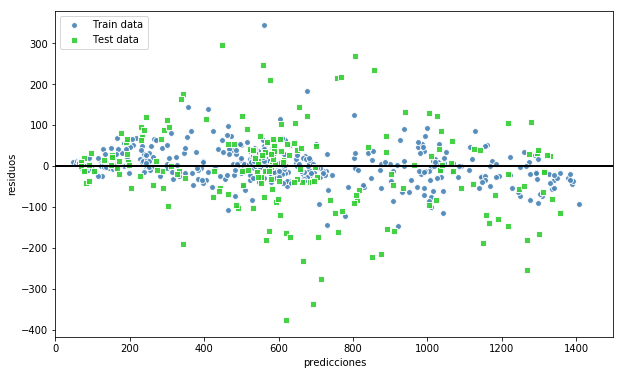

In [30]:
fig = plt.figure(figsize=(10,6))
plt.scatter(y_train_pred, y_train_pred-y_train, c='steelblue', edgecolor='white', marker='o', s=35, alpha=.9, label='Train data')
plt.scatter(y_test_pred, y_test_pred-y_test, c='limegreen', edgecolor='white', marker='s', s=35, alpha=.9, label='Test data')

plt.xlabel('predicciones')
plt.ylabel('residuos')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=0, xmax=1500, lw=2, color='black')
plt.xlim([0, 1500])
plt.show()

Comprobamos que los residuos no se distribuyen de forma totalmente aleatoria en torno al 0, como idealmente deberia ser si los errores fueran aleatorios. Para subsanar este problema no existe una forma genérica, pero algunas de las opciones podrían ser probar modelos mas complejos o generar nuevas variables.